In [2]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from typing import List
import pandas as pd
import seaborn as sns

import nnts
import nnts.data
import nnts.experiments
import nnts.models
import nnts.torch.models
import nnts.metrics
import nnts.torch.data
import nnts.torch.data.datasets
import nnts.loggers
import nnts.torch.models.trainers
import covs 
import nnts.experiments.plotting
import metric_generator


sns.set()

%load_ext autoreload
%autoreload 2

/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [3]:
def load_metrics(path, name):
    return torch.load(f"{path}/{name}_metrics.pt")

In [6]:
#PATH = f"results/{model_name}/{metadata.dataset}"
ARTICLE_PATH = "/Users/garethdavies/Development/workspaces/garethmd.github.io/articles/figures"

In [7]:
def create_scenarios(df_orig: pd.DataFrame, metadata: nnts.data.Metadata, covariates: int):
    ''' create scenarios for a dataset with a given number of covariates'''
    scenario_list: List[nnts.experiments.CovariateScenario] = []
    # Models for full forecast horizon with covariates
    scenario_list.append(
        nnts.experiments.CovariateScenario(metadata.prediction_length, 0, covariates=0),
    )
    for error in covs.errors[metadata.dataset]:
        scenario_list.append(
            nnts.experiments.CovariateScenario(
                metadata.prediction_length, error, covariates=covariates
            )
        )

    scenario_list = covs.prepare_scenarios(df_orig, scenario_list)
    selected_scenarios = [scenario_list[i] for i in [0, 1, 3, 8]]
    return selected_scenarios

Saving to /Users/garethdavies/Development/workspaces/garethmd.github.io/articles/figures/base-lstm_electricity_k_1_trajectory.png
Saving to /Users/garethdavies/Development/workspaces/garethmd.github.io/articles/figures/seg-lstm_electricity_k_1_trajectory.png
Saving to /Users/garethdavies/Development/workspaces/garethmd.github.io/articles/figures/base-lstm_electricity_k_2_trajectory.png
Saving to /Users/garethdavies/Development/workspaces/garethmd.github.io/articles/figures/seg-lstm_electricity_k_2_trajectory.png
Saving to /Users/garethdavies/Development/workspaces/garethmd.github.io/articles/figures/base-lstm_electricity_k_3_trajectory.png
Saving to /Users/garethdavies/Development/workspaces/garethmd.github.io/articles/figures/seg-lstm_electricity_k_3_trajectory.png


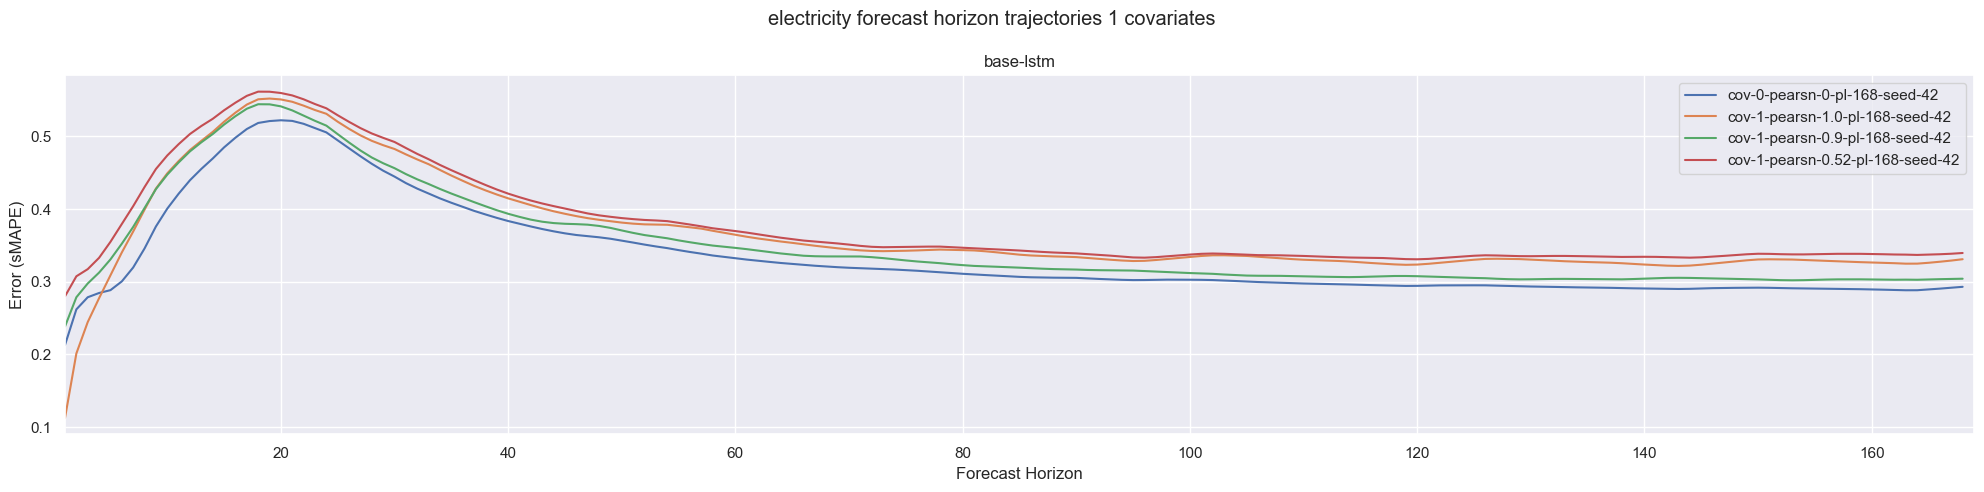

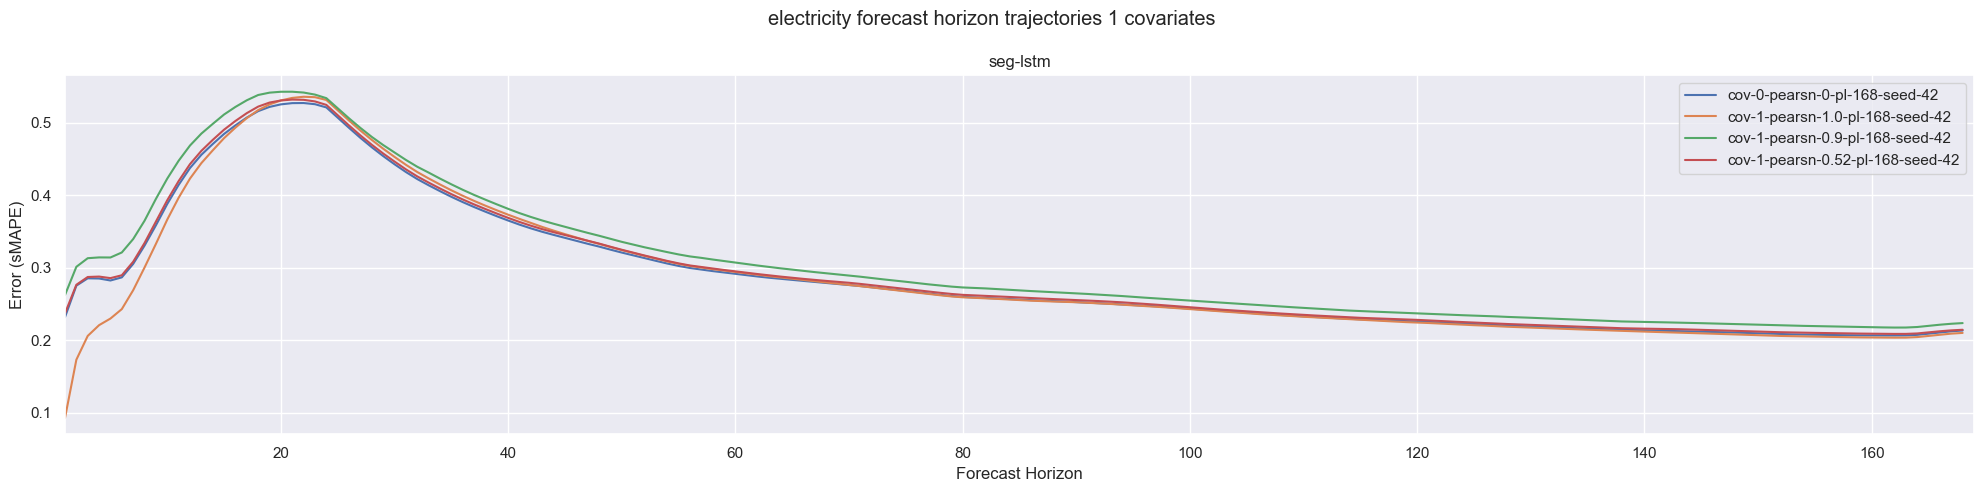

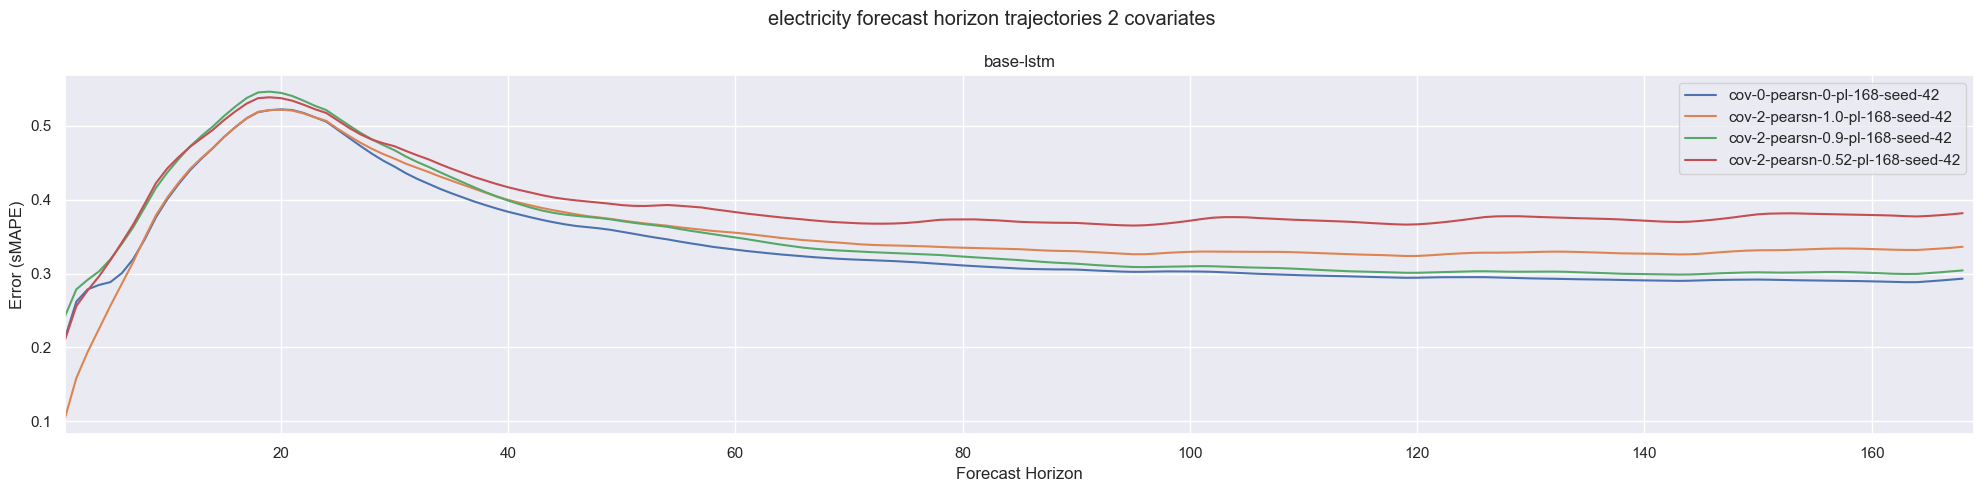

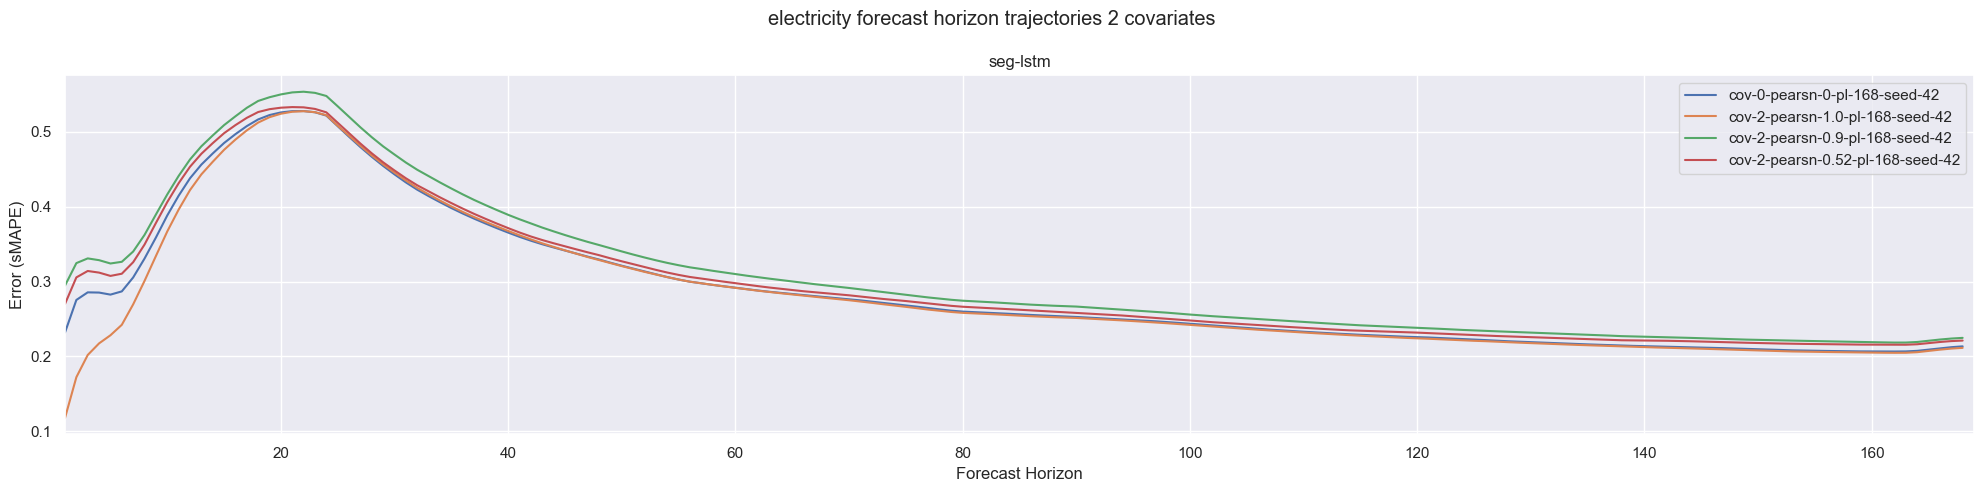

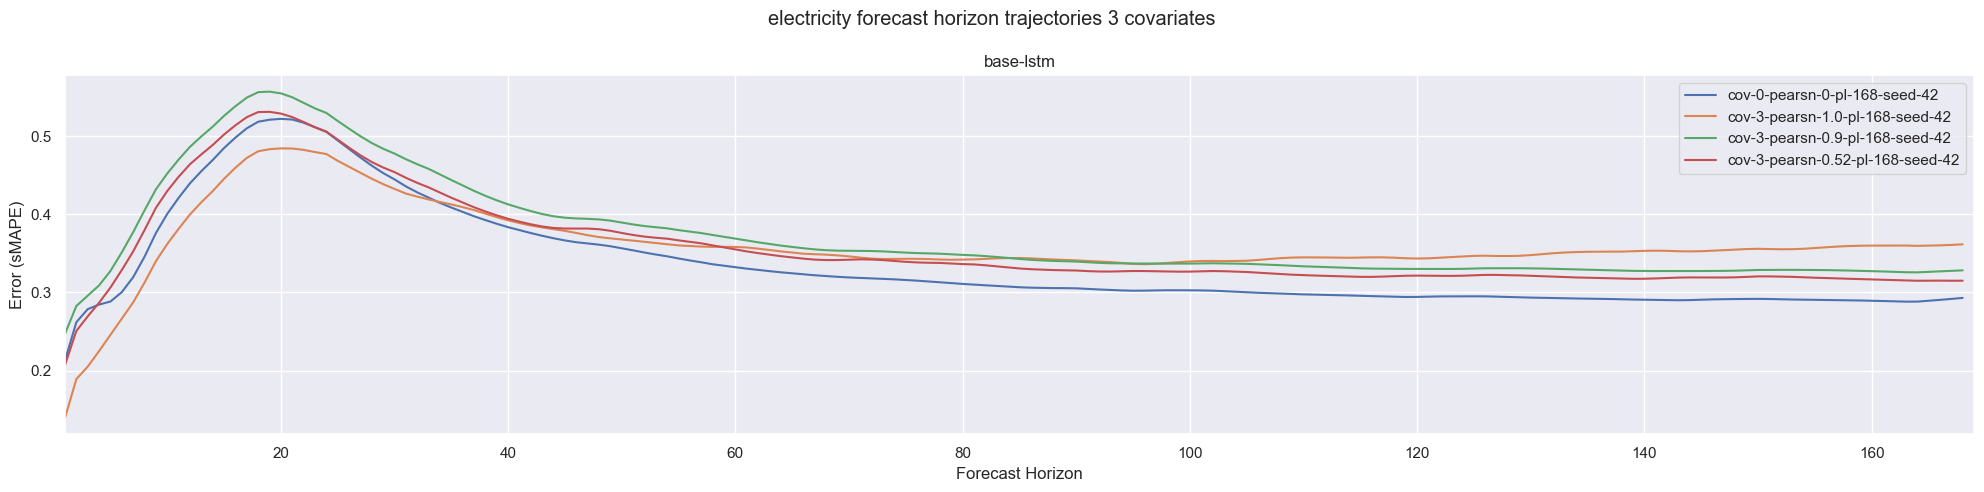

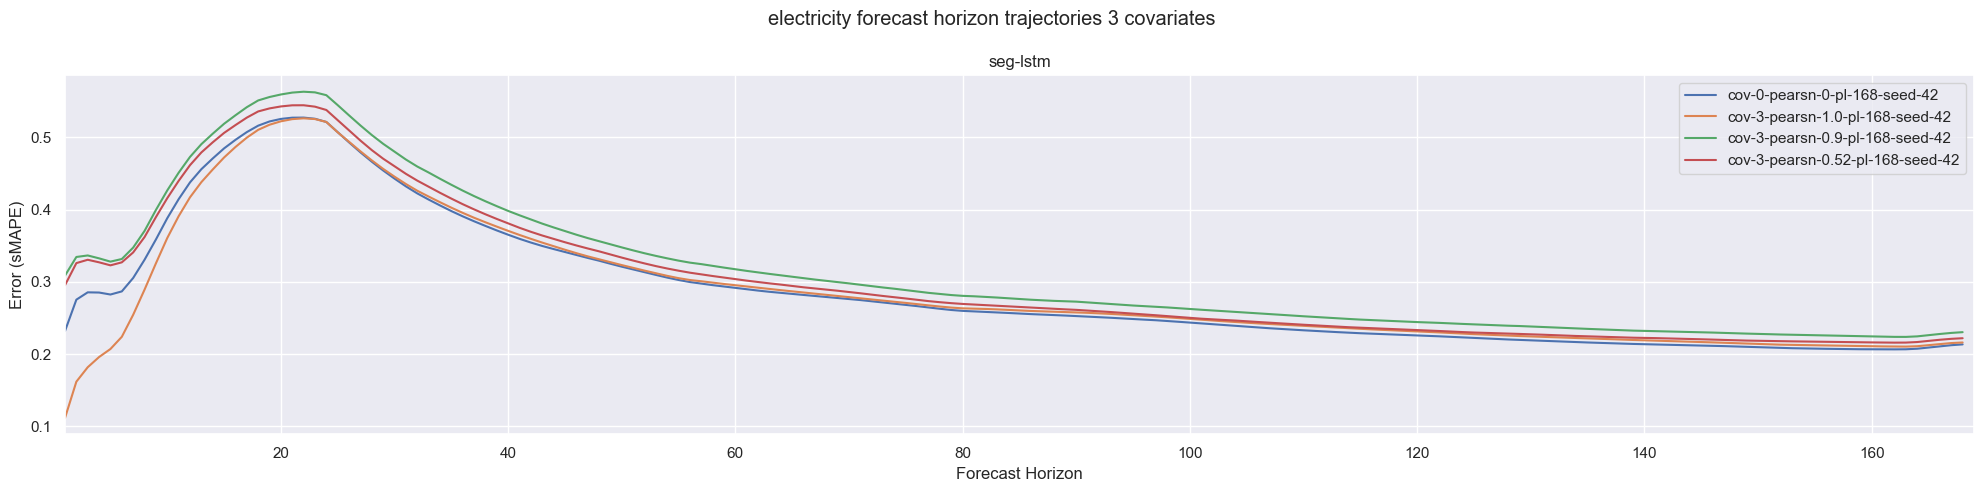

In [8]:
# plot model vs model comparison of smape as a function forecast horizon by PCC with covariates fixed
# 5.1.2 Comparing PCC over longer forecast horizons
for dataset_name in ["hospital", "tourism", "traffic", "electricity"]:
    df_orig, metadata = nnts.data.load(dataset_name)
    for covariates in [1, 2, 3]:
        for model_name in ["base-lstm", "seg-lstm"]:
            selected_scenarios = create_scenarios(df_orig, metadata, covariates)
            nnts.experiments.plotting.plot_forecast_horizon_trajectories(
                selected_scenarios,
                metadata.dataset,
                covariates,
                [model_name],
                loader_fn=load_metrics,
                path = ARTICLE_PATH
            )

Saving to /Users/garethdavies/Development/workspaces/garethmd.github.io/articles/figures/base-lstm_seg-lstm_electricity_k_1_trajectory.png
Saving to /Users/garethdavies/Development/workspaces/garethmd.github.io/articles/figures/base-lstm_seg-lstm_electricity_k_2_trajectory.png
Saving to /Users/garethdavies/Development/workspaces/garethmd.github.io/articles/figures/base-lstm_seg-lstm_electricity_k_3_trajectory.png


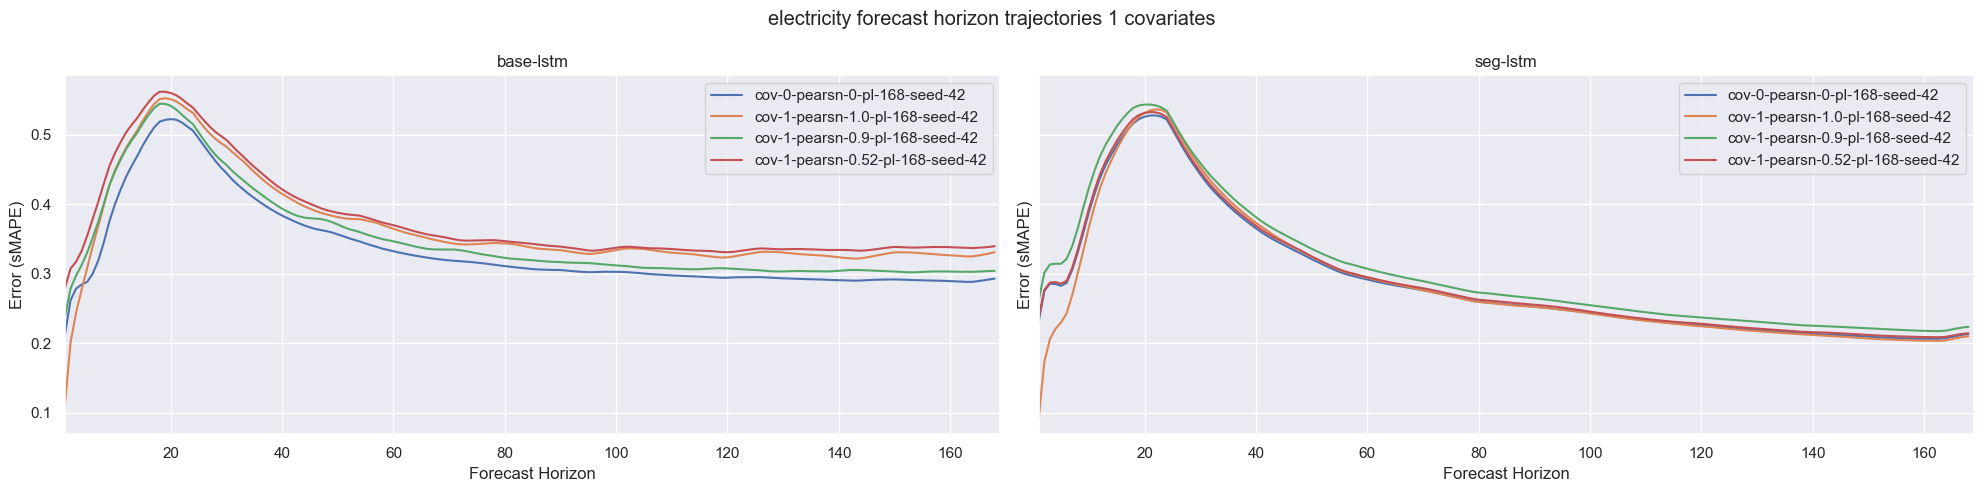

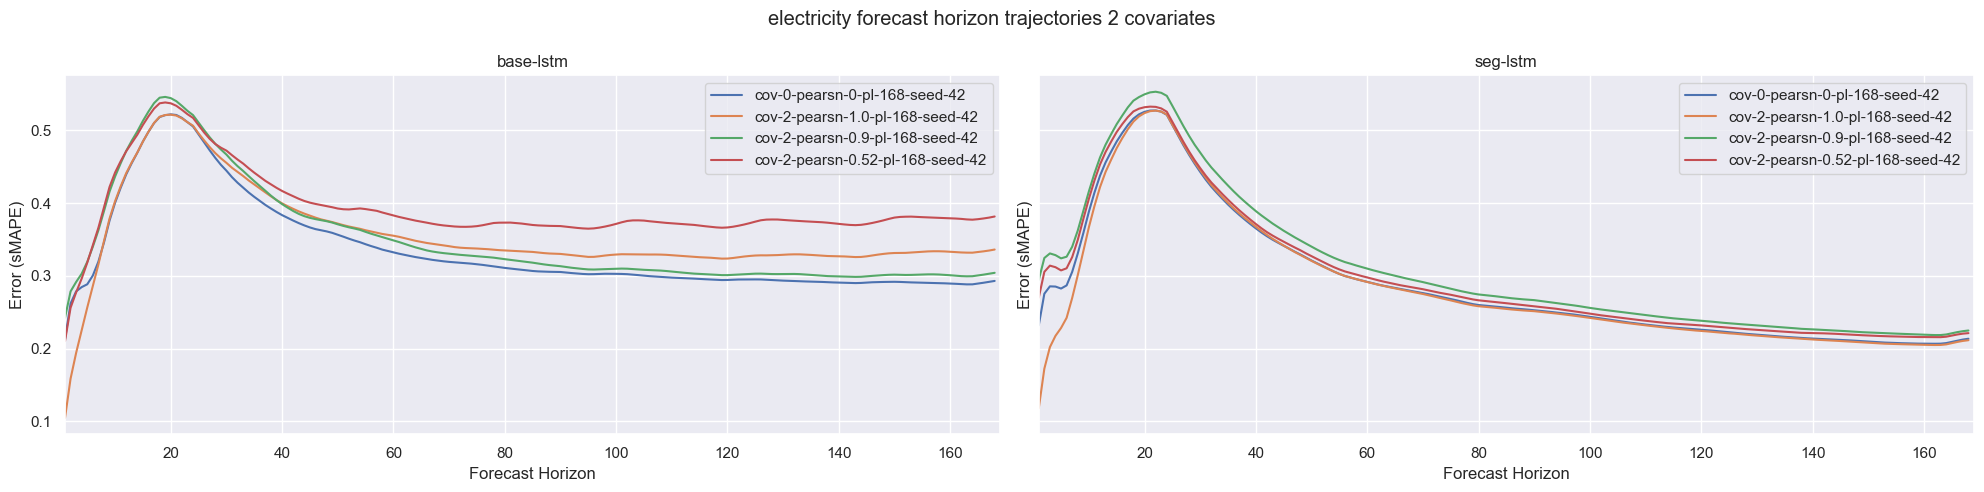

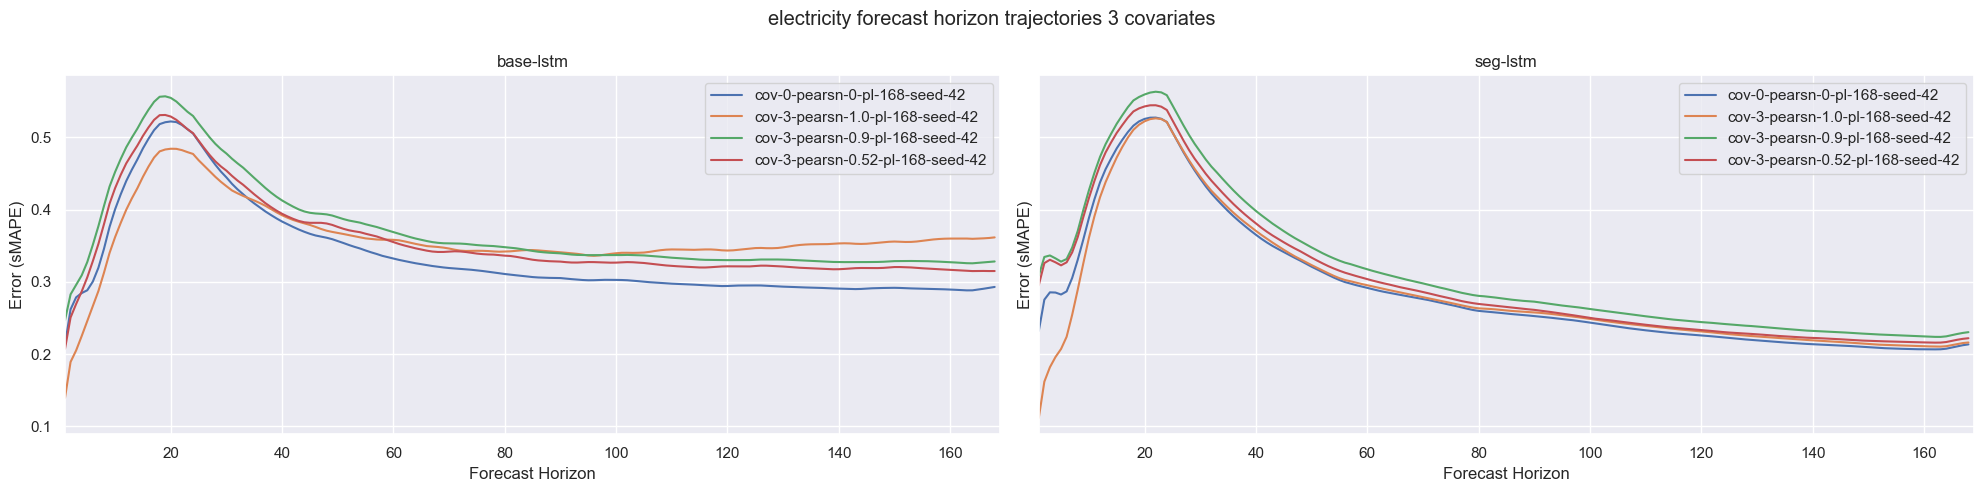

In [9]:
# 5.1.3 Comparing base-lstm and seg-lstm performance
for dataset_name in ["hospital", "tourism", "traffic", "electricity"]:
    df_orig, metadata = nnts.data.load(dataset_name)
    for covariates in [1, 2, 3]:
        selected_scenarios = create_scenarios(df_orig, metadata, covariates)
        nnts.experiments.plotting.plot_forecast_horizon_trajectories(
            selected_scenarios,
            metadata.dataset,
            covariates,
            ["base-lstm", "seg-lstm"],
            loader_fn=load_metrics,
            path=ARTICLE_PATH,
        )

Saving to /Users/garethdavies/Development/workspaces/garethmd.github.io/articles/figures/base-lstm_seg-lstm_electricity_k_0_1_2_3_trajectory.png


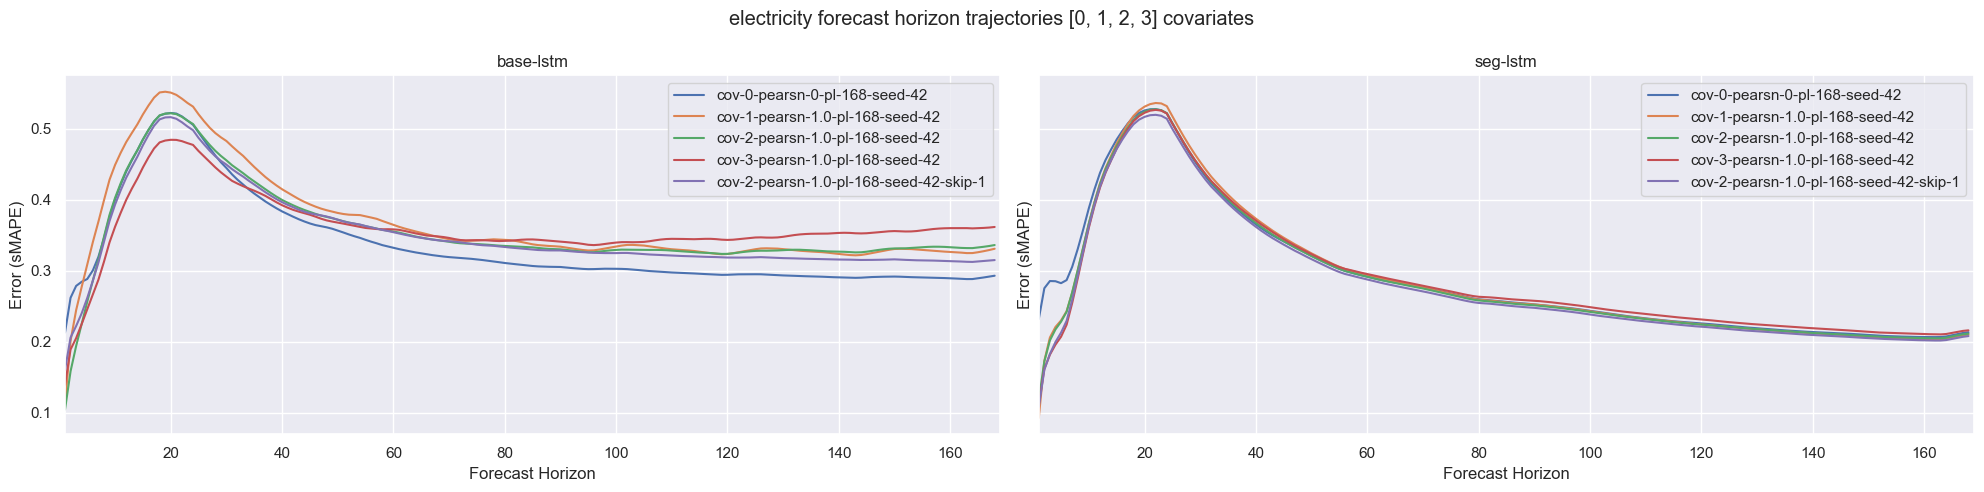

In [10]:
# 5.1.4 Comparing covariates across Forecast Horizon trajectories
# plot model vs model comparison of smape as a function forecast horizon by covariates with PCC fixed
for dataset_name in ["hospital", "tourism", "traffic", "electricity"]:
    df_orig, metadata = nnts.data.load(dataset_name)
    scenario_list: List[nnts.experiments.CovariateScenario] = []
    covariate_list = [0, 1, 2, 3]
    for covariates in covariate_list:
        scenario_list.append(
            nnts.experiments.CovariateScenario(
                metadata.prediction_length, covs.errors[metadata.dataset][0], covariates=covariates
            )
        )
    scenario_list.append(
        nnts.experiments.CovariateScenario(
            metadata.prediction_length, 0, covariates=3, skip=1
        ),
    )
    scenario_list = covs.prepare_scenarios(df_orig, scenario_list)
    nnts.experiments.plotting.plot_forecast_horizon_trajectories(
        scenario_list, metadata.dataset, covariate_list, ["base-lstm", "seg-lstm"], loader_fn=load_metrics, path=ARTICLE_PATH
    )

In [11]:
dataset_list = ["hospital", "tourism", "traffic", "electricity"]

for model_name in ["base-lstm", "seg-lstm"]:
    for scenario_covariate in [1,2,3]:
        fig = covs.plot_pcc_charts(
            model_name, scenario_covariate, dataset_list, path=ARTICLE_PATH
        )

/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/gluonts/evaluation/metrics.py:116: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs(target - forecast) / np.abs(target))


Saving to /Users/garethdavies/Development/workspaces/garethmd.github.io/articles/figures/base-lstm_k_1_smape_vs_pearson.png


/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/gluonts/evaluation/metrics.py:116: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs(target - forecast) / np.abs(target))
/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/gluonts/evaluation/metrics.py:116: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs(target - forecast) / np.abs(target))


Saving to /Users/garethdavies/Development/workspaces/garethmd.github.io/articles/figures/base-lstm_k_2_smape_vs_pearson.png


/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/gluonts/evaluation/metrics.py:116: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs(target - forecast) / np.abs(target))
/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/gluonts/evaluation/metrics.py:116: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs(target - forecast) / np.abs(target))


Saving to /Users/garethdavies/Development/workspaces/garethmd.github.io/articles/figures/base-lstm_k_3_smape_vs_pearson.png


/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/gluonts/evaluation/metrics.py:116: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs(target - forecast) / np.abs(target))


Saving to /Users/garethdavies/Development/workspaces/garethmd.github.io/articles/figures/seg-lstm_k_1_smape_vs_pearson.png


/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/gluonts/evaluation/metrics.py:116: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs(target - forecast) / np.abs(target))
/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/gluonts/evaluation/metrics.py:116: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs(target - forecast) / np.abs(target))


Saving to /Users/garethdavies/Development/workspaces/garethmd.github.io/articles/figures/seg-lstm_k_2_smape_vs_pearson.png


/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/gluonts/evaluation/metrics.py:116: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs(target - forecast) / np.abs(target))
/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/gluonts/evaluation/metrics.py:116: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs(target - forecast) / np.abs(target))


Saving to /Users/garethdavies/Development/workspaces/garethmd.github.io/articles/figures/seg-lstm_k_3_smape_vs_pearson.png


In [5]:
# Generate data for analysis - required once only after model training
for dataset in ["hospital", "tourism", "traffic", "electricity"]:
    model_name = "base-lstm"
    df_orig, metadata = nnts.data.load(dataset)

    if model_name == "seg-lstm":
        metadata.context_length = (
            metadata.prediction_length * 8 + 1
            if metadata.dataset == "traffic"
            else metadata.prediction_length * 3 + 1
        )
        metadata.seasonality = 8 if metadata.dataset == "traffic" else metadata.seasonality
    params = nnts.models.Hyperparams()

    scenario_list: List[nnts.experiments.CovariateScenario] = []
    # Add the baseline scenarios
    scenario_list.append(
        nnts.experiments.CovariateScenario(
            metadata.prediction_length, error=0.0, covariates=0
        )
    )
    # Models for full forecast horizon with covariates
    for covariates in [1, 2, 3]:
        for error in covs.errors[metadata.dataset]:
            scenario_list.append(
                nnts.experiments.CovariateScenario(
                    metadata.prediction_length, error, covariates=covariates
                )
            )
    scenario_list.append(
        nnts.experiments.CovariateScenario(
            metadata.prediction_length, 0, covariates=3, skip=1
        )
    )
    metric_generator.generate(scenario_list, df_orig, metadata, params, model_name, f"results/{model_name}/{metadata.dataset}")

/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/gluonts/evaluation/metrics.py:116: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs(target - forecast) / np.abs(target))
/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/gluonts/evaluation/metrics.py:116: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs(target - forecast) / np.abs(target))
/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of

In [57]:
dataset = "traffic"
model_name = "seg-lstm"
csv_aggregator = covs.CSVFileAggregator(f'results/{model_name}/{dataset}', "results")
results = csv_aggregator()
df_orig, metadata = nnts.data.load(dataset)

In [58]:
results.loc[
    (results["covariates"] == 0)
    & (results["prediction_length"] == metadata.prediction_length),
    ["smape", "mae", "rmse"],
].mean()

smape    0.129747
mae      1.167390
rmse     1.580042
dtype: float64

In [59]:
cols = ["dataset", "error", "pearson", "covariates", "prediction_length", "smape"]
results.loc[
    (results["covariates"] > 0)
    & (results["error"].isin([0.000000, 0.17142857142857143, 0.6]))
    & (results["skip"] == 0),
    cols,
].sort_values(by=["covariates", "error"]).pivot_table(
    index=["dataset", "covariates"], columns=["pearson"], values="smape"
)

pearson             0.520039  0.905151  1.000000
dataset covariates                              
traffic 1           0.130060  0.128513  0.116385
        2           0.128588  0.131230  0.110973
        3           0.128986  0.119473  0.098786

In [55]:
results['error'].unique().tolist()

[0.0,
 0.6,
 0.2571428571428571,
 0.34285714285714286,
 0.08571428571428572,
 0.5142857142857142,
 0.17142857142857143,
 0.4285714285714286]

In [ ]:
df_list = covs.add_y_hat(df, y_hat, scenario.prediction_length)
sample_preds = covs.plot(df_list, scenario.prediction_length)

In [13]:
(
    0.12695613503456116
    + 0.12665991485118866
    + 0.12529781460762024
    + 0.12532585859298706
    + 0.12746426463127136
) / 5

0.1263407975435257